In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [2]:
import numpy as np
from src.mask_pattern import LinePattern

In [3]:
from src import const
mask = LinePattern(cd=56, gap=80, direction="V", field_type="DF")(const.NDIVX, const.NDIVY)

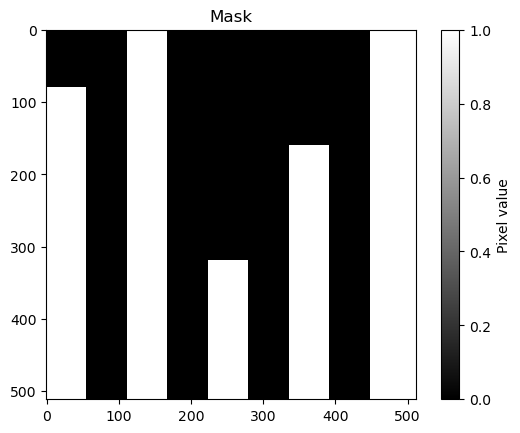

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

In [5]:
def exponential(FDIV):
    cexp = np.empty(FDIV, dtype=complex)
    for i in range(FDIV):
        cexp[i] = np.exp(-2.0 * np.pi * 1.0j * i / FDIV)
    return cexp

expx = exponential(const.FDIVX)
expy = exponential(const.FDIVY)

def original_mask(pattern_mask, ampta, ampvc, FDIVX, FDIVY, LMAX, MMAX, expx, expy):

    meshX = const.FDIVX // const.NDIVX
    meshY = const.FDIVY // const.NDIVY

    # --- パターン行列を初期化 ---
    pattern = np.zeros((const.FDIVX, const.FDIVY), dtype=np.complex128)

    # --- マスクを展開してパターン生成 ---
    for i in range(const.FDIVX):
        ii = i // meshX
        for j in range(const.FDIVY):
            jj = j // meshY
            if pattern_mask[ii, jj] == 1:  # mask2d が 1次元フラットな場合
                pattern[i, j] = ampta
            else:
                pattern[i, j] = ampvc


    # @jit
    def fourier(FDIV, ll, f, cexp):
        sum = 0.0 + 0.0j
        for i in range(FDIV):
            il = (i * ll) % FDIV
            sum += f[i] * cexp[il]
        return sum / FDIV

    Lrange2 = 4 * LMAX + 1
    Mrange2 = 4 * MMAX + 1
    ampx = np.zeros(FDIVX, dtype=complex)
    ampy = np.zeros(FDIVY, dtype=complex)
    ftmp = np.zeros((FDIVX, Mrange2), dtype=complex)
    famp = np.zeros((Lrange2, Mrange2), dtype=complex)
    for i in range(FDIVX):
        for ij in range(FDIVY):
            ampy[ij] = pattern[i, ij]
        for ij in range(int((Mrange2 + 1) / 2)):
            ftmp[i, ij] = fourier(FDIVY, ij, ampy, expy)
        for ij in range(int((Mrange2 + 1) / 2), Mrange2):
            m = ij - Mrange2
            ftmp[i, ij] = fourier(FDIVY, m, ampy, expy)
            
    for ij in range(Mrange2):
        for i in range(FDIVX):
            ampx[i] = ftmp[i, ij]
        for i in range(int((Lrange2 + 1) / 2)):
            famp[i, ij] = fourier(FDIVX, i, ampx, expx)
        for i in range(int((Lrange2 + 1) / 2), Lrange2):
            ll = i - Lrange2
            famp[i, ij] = fourier(FDIVX, ll, ampx, expx)
    return famp

In [6]:
ata = 0.95 + 0.0j
avc = 1.0 + 0.0j
org_fft_mask = original_mask(mask, ata, avc, const.FDIVX, const.FDIVY, const.LMAX, const.MMAX, expx, expy)

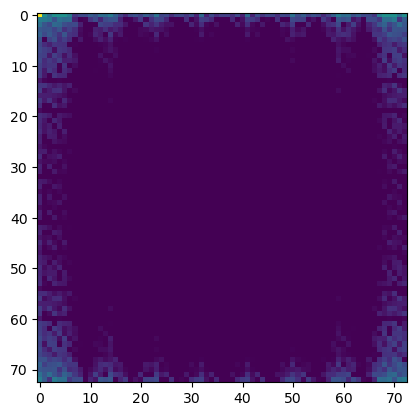

In [7]:
org_vis_mask = np.maximum(np.log(np.abs(org_fft_mask)) + 10, 0)
plt.imshow(org_vis_mask)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


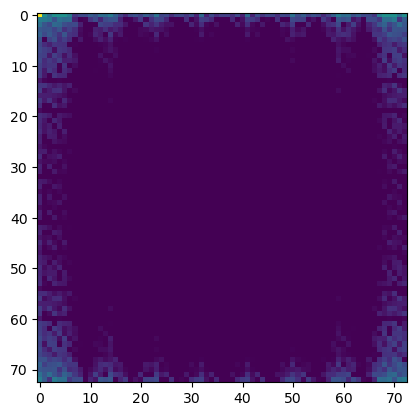

In [8]:
%load_ext autoreload
%autoreload 2
from src import fourier
our_mask = fourier.mask(mask, ata, avc)
our_vis_mask = np.maximum(np.log(np.abs(our_mask)) + 10, 0)
plt.imshow(our_vis_mask)
plt.show()

In [9]:
meshX = const.FDIVX // const.NDIVX
meshY = const.FDIVY // const.NDIVY
pattern = np.where(
    np.kron(mask, np.ones((meshX, meshY))), ata, avc
).astype(
    np.complex128
) 
pattern.shape, pattern.dtype

((512, 512), dtype('complex128'))

In [10]:
ftmp = np.fft.fftshift(pattern, axes=0)
ftmp.shape, ftmp.dtype    

((512, 512), dtype('complex128'))

In [11]:
meshX = const.FDIVX // const.NDIVX
meshY = const.FDIVY // const.NDIVY
meshX, meshY

(1, 1)

In [12]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
a = np.arange(10)
np.roll(a, 3)[:6]

array([7, 8, 9, 0, 1, 2])

In [14]:
import numpy as np
from src import fourier

ampta = 0.95 + 0.0j
ampvc = 1.0 + 0.0j
famp = fourier.mask(mask, ampta, ampvc)
rfamp = np.maximum(np.log(np.abs(famp)) + 10, 0)

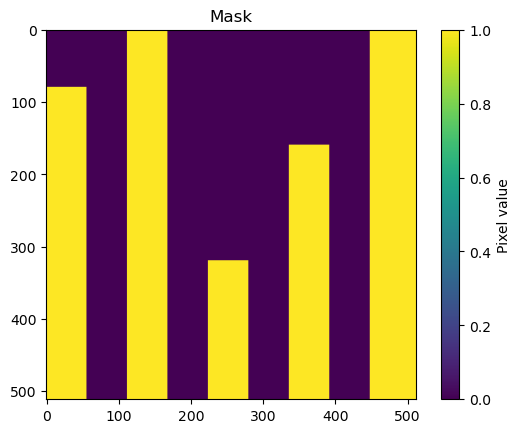

In [15]:
plt.imshow(mask)
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()